# Building model for car value estimator

In [9]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from skl2onnx.common.data_types import FloatTensorType
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster
import json
import shap

In [10]:
dataset = pd.read_csv('car_value_training_data_v2.csv')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  114000 non-null  int64 
 1   Make        114000 non-null  object
 2   Model       114000 non-null  object
 3   Year        114000 non-null  int64 
 4   Miles       114000 non-null  int64 
 5   Condition   114000 non-null  object
 6   Value       114000 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 6.1+ MB


In [11]:
# Identify data and target
X = dataset[['Make', 'Model', 'Year', 'Miles', 'Condition']].copy()
y = dataset['Value'].copy()

In [12]:
# Map categorical conditions to integer values
condition_mapping = {
    'Poor'      :1,
    'Fair'      :2,
    'Good'      :3,
    'Great'     :4,
    'Excellent' :5,
    'Like New'  :6,
}

# Apply the mapping
X['Condition'] = X['Condition'].map(condition_mapping)

In [13]:
# Integer mapping make yields acceptable accuracy as one hot encoding (difference of 0.005 MAPE in test)
make_mapping = {
    'Acura'         :10, 
    'Audi'          :11, 
    'BMW'           :12, 
    'Chevrolet'     :13, 
    'Chrysler'      :14, 
    'Dodge'         :15, 
    'Ford'          :16, 
    'GMC'           :17, 
    'Honda'         :18, 
    'Hyundai'       :19, 
    'Jeep'          :20, 
    'Kia'           :21, 
    'Lexus'         :22, 
    'Mazda'         :23, 
    'Mercedes-Benz' :24, 
    'Nissan'        :25, 
    'Porsche'       :26, 
    'Subaru'        :27, 
    'Tesla'         :28, 
    'Toyota'        :29, 
    'Volkswagen'    :30, 
    'Volvo'         :31,
}

# Apply the mapping
X['Make'] = X['Make'].map(make_mapping)

In [14]:
model_mapping = {
    # Acura
    'NSX':104, 'MDX':103, 'RDX': 102, 'TLX': 101, 'ILX': 100, 
    # Audi
    'R8': 117, 'Q8': 116, 'A8': 115, 'Q7': 114, 'A6': 113, 'Q5': 112, 'A4': 111, 'Q3':110, 
    # BMW
    '8 Series': 129, '7 Series': 128, 'X7': 127, 'X6': 126, 'X5': 125, '5 Series': 124, 
    '3 Series': 123, 'X3': 122, '2 Series': 121, '1 Series': 120,
    # Cadillac
    'Escalade': 135, 'CT6': 134, 'XT6': 133, 'XT5': 132, 'CT5': 131, 'XT4': 130,
    # Chevrolet
    'Corvette': 149, 'Silverado': 148, 'Tahoe': 147, 'Suburban': 146, 'Traverse': 145, 'Equinox': 144,
    'Malibu': 143, 'Trax': 142, 'Spark': 141, 'Sonic': 140, 
    # Chrysler
    'Pacifica': 153, '300': 152, 'Voyager': 151, 'PT Cruiser': 150, 
    # Dodge
    'Challenger': 164, 'Ram': 163, 'Charger': 162, 'Durango': 161, 'Journey': 160, 
    # Ford
    'Mustang': 179, 'F-150': 178, 'Expedition': 177, 'Explorer': 176, 'Edge': 175, 'Escape': 174,
    'Ranger': 173, 'Fusion': 172, 'EcoSport': 171, 'Fiesta': 170, 
    # GMC
    'Sierra': 184, 'Yukon': 183, 'Acadia': 182, 'Terrain': 181, 'Canyon1': 180, 
    # Honda
    'Odyssey': 198, 'Pilot': 197, 'Passport': 196, 'Ridgeline': 195, 'Accord': 194, 'CR-V': 193,
    'Civic': 192, 'HR-V': 191, 'Fit': 190, 
    # Hyundai
    'Palisade': 207, 'Santa Fe': 206, 'Sonata': 205, 'Tucson': 204, 'Elantra': 203, 'Kona': 202,
    'Accent': 201, 'Venue': 200, 
    # Jeep
    'Gladiator': 216, 'Grand Wagoneer': 215, 'Wrangler': 214, 'Grand Cherokee': 213, 'Cherokee': 212, 
    'Compass': 211, 'Renegade': 210, 
    # Kia
    'Telluride': 227, 'K900': 226, 'Stinger': 225, 'Sorento': 224, 'Sportage': 223, 'Forte': 222, 
    'Soul': 221, 'Rio': 220, 
    # Lexus
    'LX': 237, 'LS': 236, 'LC': 235, 'GX': 234, 'RX': 233, 'NX': 232, 'ES': 231, 'UX': 230, 
    # Mazda
    'CX-9': 244, 'MX-5 Miata': 243, 'CX-5': 242, 'Mazda6': 241, 'Mazda3': 240, 
    # Merceds-Benz
    'S-Class': 257, 'G-Class': 256, 'E-Class': 255, 'GLS': 254, 'C-Class': 253, 'GLC': 252,
    'A-Class': 251, 'CLA-Class': 250, 
    # Nissan
    'GT-R': 269, 'Armada': 268, 'Titan': 267, 'Pathfinder': 266, 'Murano': 265, 'Rogue': 264, 
    'Maxima': 263, 'Altima': 262, 'Sentra': 261, 'Versa': 260, 
    # Porsche
    '911': 276, 'Taycan': 275, 'Panamera': 274, 'Cayenne': 273, 'Macan': 272, '718 Boxster': 271,
    '718 Cayman': 270, 
    # Subaru
    'Ascent': 286, 'Outback': 285, 'Forester': 284, 'Crosstrek': 283, 'Legacy': 282, 'Impreza': 281,
    'WRX': 280, 
    # Tesla
    'Model S': 293, 'Model X': 292, 'Model 3': 291, 'Model Y': 290, 
    # Toyota
    'Seqoia': 309, 'Tundra': 308, '4runner': 307, 'Tacoma': 306, 'Avalon': 305,'Highlander': 304, 
    'RAV4': 303, 'Camry': 302, 'Corolla': 301, 'Prius': 300, 
    # Volkwagen
    'Touareg': 317, 'Arteon': 316, 'Atlas': 315, 'Passat': 314, 'Tiguan': 313, 'Golf': 312,
    'Jetta': 311, 'ID.4': 310, 
    # Volvo
    'XC90': 327, 'XC60': 326, 'S90': 325, 'V90 Cross Country': 324, 'XC40': 323, 'S60': 322, 
    'V60 Cross Country': 321, 'V60': 320,
}

# Apply the mapping
X['Model'] = X['Model'].map(model_mapping)

In [15]:
X

,Make,Model,Year,Miles,Condition
0,21.0,226,2020,90367,3
1,12.0,121,2022,48783,4
2,17.0,181,2021,41066,4
3,31.0,327,2018,87144,2
4,26.0,274,2011,202063,3
...,...,...,...,...,...
113995,16.0,176,2020,178084,3
113996,30.0,314,2020,211522,4
113997,26.0,273,2020,195677,3
113998,28.0,292,2023,81194,4


In [427]:
## Note: One hot encoding the Make column did not produce significant benefit (0.005 improvement to MAPE)


# One hot encode the 'Make' column
#make_dummies = pd.get_dummies(X['Make'], prefix='', prefix_sep='').astype(int)

# Concatenate the dummy variables with the original DataFrame
#X = pd.concat([X, make_dummies], axis=1)

# Drop the original 'Make' column
#X.drop('Make', axis=1, inplace=True)

#X

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15)

In [61]:
print('Training set:', X_train.shape, y_train.shape)
print('Testing set: ', X_test.shape, y_test.shape)

Training set: (96900, 5) (96900,)
Testing set:  (17100, 5) (17100,)


In [62]:
X_train

,Make,Model,Year,Miles,Condition
60229,11.0,114,2021,68764,3
67530,14.0,151,2019,29086,2
88839,13.0,143,2017,40785,2
69837,11.0,115,2023,26903,4
24149,10.0,101,2014,223219,4
...,...,...,...,...,...
40318,14.0,151,2023,21218,5
17892,17.0,180,2016,33214,3
35288,16.0,176,2005,273717,3
67886,21.0,223,2018,90161,4


In [63]:
regressor = xgb.XGBRegressor(eta = 0.12, max_depth= 13) # 0.013 on integer makes
#regressor = xgb.XGBRegressor(eta = 0.37, max_depth= 13)  # tested 0.013 with one hot encoded makes, best parameters remained same


regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

In [64]:
score = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)

score # ~98.5% accuracy

0.013002983607644918

In [65]:
cv_scores = cross_val_score(regressor, X, y, scoring='neg_mean_absolute_percentage_error', cv=5)
print(f"Cross-Validation MAPE: {-cv_scores.mean()}")


Cross-Validation MAPE: 0.05942949027841996


In [66]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

MAE: 142.09143995496962
MSE: 94016.2503740781
RMSE: 306.62069462787093
R-squared: 0.9989557087373838


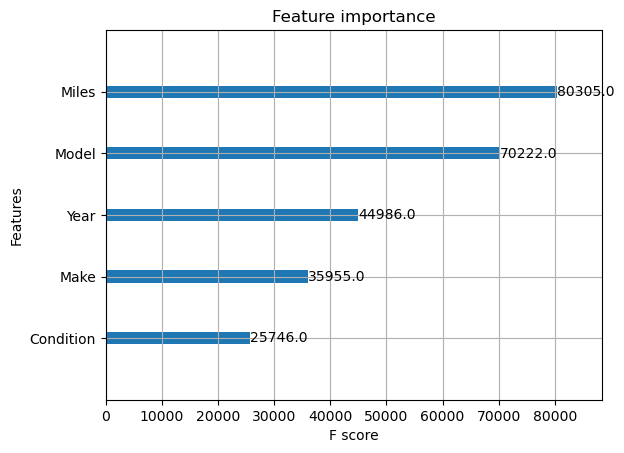

In [67]:
import matplotlib.pyplot as plt
xgb.plot_importance(regressor)
plt.show()

In [68]:
# Initialize the SHAP explainer
#explainer = shap.Explainer(regressor)
#shap_values = explainer(X_test)

# Plot the SHAP summary
#shap.summary_plot(shap_values, X_test)

## Export XGBoost model as ONNX model

In [69]:
# Create a mapping for feature names
feature_names = [f'f{i}' for i in range(X_train.shape[1])]
feature_mapping = {old_name: new_name for old_name, new_name in zip(X_train.columns, feature_names)}

# Rename the features in the training data
X_train_renamed = X_train.rename(columns=feature_mapping)
X_test_renamed = X_test.rename(columns=feature_mapping)

# Re-train the model with renamed features
regressor = xgb.XGBRegressor(eta=0.12, max_depth=13)
regressor.fit(X_train_renamed, y_train)

# Convert the model to ONNX format
onnx_model = convert_xgboost_booster(regressor, initial_types=[('float_input', FloatTensorType([None, X_train_renamed.shape[1]]))])

# Save the model to disk
with open("car_value_xgb_regressor.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

# Save the feature mapping to a JSON file
with open("car_value_feature_mapping.json", "w") as f:
    json.dump(feature_mapping, f)

print("Model has been converted to ONNX format and saved as 'car_value_xgb_regressor.onnx'.")
print("Feature mapping has been saved as 'feature_mapping.json'.")

Model has been converted to ONNX format and saved as 'car_value_xgb_regressor.onnx'.
Feature mapping has been saved as 'feature_mapping.json'.


In [70]:
X_train_renamed

,f0,f1,f2,f3,f4
60229,11.0,114,2021,68764,3
67530,14.0,151,2019,29086,2
88839,13.0,143,2017,40785,2
69837,11.0,115,2023,26903,4
24149,10.0,101,2014,223219,4
...,...,...,...,...,...
40318,14.0,151,2023,21218,5
17892,17.0,180,2016,33214,3
35288,16.0,176,2005,273717,3
67886,21.0,223,2018,90161,4


In [87]:
test_data = {'f0':[16] , 'f1': [130], 'f2': [2018], 'f3': [10000], 'f4': [6]}
test_data = pd.DataFrame(test_data)
test_pred = regressor.predict(test_data)

print(test_data)
print(test_pred)

   f0   f1    f2     f3  f4
0  16  130  2018  10000   6
[24103.57]
